<a href="https://colab.research.google.com/github/lishuaifu/gan/blob/master/gati_gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
# 连接Google云盘的操作，左边会显示文件的绝对路径
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# 将解压的所有图片压缩成hdf5格式的文件存储照片
import h5py,zipfile,imageio,os

hdf5_file = '/content/drive/MyDrive/gait_gan /gaitgan.h5py'
Celeba_file='/content/drive/MyDrive/gait_gan /90-Image.zip'
# !unzip "/content/drive/MyDrive/gait_gan /90-Image.zip" -d "/content/drive/My Drive/"
total_images = 7400 # 你需要打包的图片数量

img_path = '/content/drive/MyDrive/90-Image'
imgs = os.listdir(img_path)
with h5py.File(hdf5_file, 'w') as hf:
    count = 0
    for i in imgs:
                # 图片提取
      i = '/content/drive/MyDrive/90-Image/' + i         
      print(i)         
      img = imageio.imread(i)

                # 添加数据到HDF5文件
      hf.create_dataset('gait_gan_hdf5/' + str(count) + '.png', data=img, compression="gzip", compression_opts=9)

                # 停止控制
      count += 1
      if (count == total_images):
        break



# 新段落

In [60]:
# imageio.help()

In [48]:
import h5py

import numpy as np
import matplotlib.pyplot as plt

with h5py.File('/content/drive/MyDrive/gait_gan /gaitgan.h5py', 'r') as file_object:
  for group in file_object:
    print(group)
    pass

gait_gan_hdf5


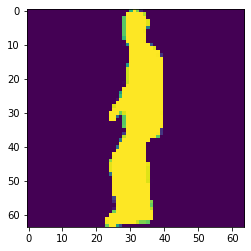

In [64]:
with h5py.File('/content/drive/MyDrive/gait_gan /gaitgan.h5py', 'r') as file_object:
  dataset = file_object['gait_gan_hdf5']
  image = np.array(dataset['0.png'])
  plt.imshow(image, interpolation='none')
  pass

In [43]:
image.shape

(64, 64)

In [58]:
f = h5py.File('/content/drive/MyDrive/gait_gan /gaitgan.h5py', 'r')
dset = f['gait_gan_hdf5']
a = np.array(dset['100.png'])
# for i in range(len(a)):
#   for j in range(len(a[0])):
#     print(a[i][j])

In [59]:
import torch
a_new = torch.from_numpy(a)
print(a_new)

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], dtype=torch.uint8)


In [82]:
# 读取hdf5的数据集--这个是对抗网中所给的例子
from torch.utils.data import Dataset # 将数据载入一个torch,utils.data.Dataset对象中

class Gait90Dataset(Dataset):

  def __init__(self, file):
    self.file_object = h5py.File(file,'r')
    self.dataset = self.file_object['gait_gan_hdf5']
    pass

  def __len__(self):
    """
    返回数据集中的项目总数
    """
    return len(self.dataset)

  def __getitem__(self, index):
    """
    返回数据集中的第n项
    """
    if(index >= len(self.dataset)):
      raise IndexError()
    
    img = np.array(self.dataset[str(index) + '.png']) # 将hfpy中的每一个图片处理成numpy的格式
    return torch.from_numpy(img).float() / 255
  
  def plot_img(self, index):
    plt.imshow(np.array(self.dataset[str(index) + '.png']), interpolation='nearest')
    pass

  pass


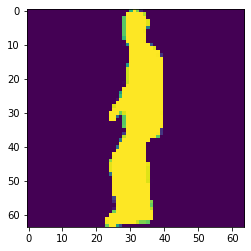

In [83]:
# 创建数据集对象，并通过索引查看图像

gait90_dataset = Gait90Dataset('/content/drive/MyDrive/gait_gan /gaitgan.h5py') # 创建对象

gait90_dataset.plot_img(0) # 查看图片

In [90]:
%%time
# 查看图片的维度

batch_size = 7400
batch = torch.zeros(batch_size, 3, 64, 64, dtype=torch.uint8) # 批量存储图像，以获得一个N*C*H*W的张量

data_dir = '/content/drive/MyDrive/90-Image/'
filenames = [name for name in os.listdir(data_dir)
    if os.path.splitext(name)[-1] == '.png']
for i,filename in enumerate(filenames):
  img_arr = imageio.imread(os.path.join(data_dir,filename))
  img_t = img_t.reshape(64, 64, 1)
  img_t = torch.from_numpy(img_arr)  # 将numpy数据转换成torch变量
  img_t = img.permute(2, 0, 1) # 修改通道的形式
  # print(img_t)
  batch[i] = img_t

batch = batch.float() # 神经网络通常使用浮点数张量作为输入
batch /= 255.0 # 归一化7

CPU times: user 4.06 s, sys: 1.33 s, total: 5.39 s
Wall time: 16.1 s


In [91]:
# 
# check if CUDA is available
# if yes, set default tensor type to cuda

if torch.cuda.is_available():
  torch.set_default_tensor_type(torch.cuda.FloatTensor)
  print("using cuda:", torch.cuda.get_device_name(0))
  pass

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

using cuda: Tesla T4


device(type='cuda')

In [92]:
# functions to generate random data

def generate_random_image(size):
    random_data = torch.rand(size)
    return random_data


def generate_random_seed(size):
    random_data = torch.randn(size)
    return random_data
     

In [94]:
# modified from https://github.com/pytorch/vision/issues/720
import torch.nn as nn
class View(nn.Module):
    def __init__(self, shape):
        super().__init__()
        self.shape = shape,

    def forward(self, x):
        return x.view(*self.shape)

In [98]:
# dataset class

class Gait90Dataset1(Dataset):

  def __init__(self, file):
    self.file_object = h5py.File(file,'r')
    self.dataset = self.file_object['gait_gan_hdf5']
    pass

  def __len__(self):
    """
    返回数据集中的项目总数
    """
    return len(self.dataset)

  def __getitem__(self, index):
    """
    返回数据集中的第n项
    """
    if(index >= len(self.dataset)):
      raise IndexError()
    
    img = np.array(self.dataset[str(index) + '.png']) # 将hfpy中的每一个图片处理成numpy的格式
    img = img.reshape(64, 64, 1)
    return torch.cuda.FloatTensor(img).permute(2,0,1).view(1,1,64,64) / 255.0
  
  def plot_image(self, index):
    plt.imshow(np.array(self.dataset[str(index) + '.png']), interpolation='nearest')
    pass

  pass



In [101]:
gait90_dataset = Gait90Dataset1('/content/drive/MyDrive/gait_gan /gaitgan.h5py') # 创建对象

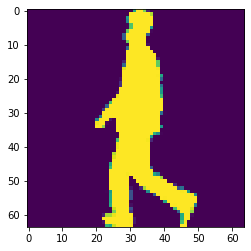

In [102]:
gait90_dataset.plot_image(43)

In [103]:
# discriminator class
import pandas
class Discriminator(nn.Module):
    
    def __init__(self):
        # initialise parent pytorch class
        super().__init__()
        
        # define neural network layers
        self.model = nn.Sequential(
            # expect input of shape (1,3,128,128)
            nn.Conv2d(1, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(128, 128, kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(128, 3, kernel_size=8, stride=2),
            nn.LeakyReLU(0.2),
            
            View(3*5*5),
            nn.Linear(3*5*5, 1),
            nn.Sigmoid()
        )
        
        # create loss function
        self.loss_function = nn.BCELoss()

        # create optimiser, simple stochastic gradient descent
        self.optimiser = torch.optim.Adam(self.parameters(), lr=0.0001)

        # counter and accumulator for progress
        self.counter = 0;
        self.progress = []

        pass
    
    
    def forward(self, inputs):
        # simply run model
        return self.model(inputs)
    
    
    def train(self, inputs, targets):
        # calculate the output of the network
        outputs = self.forward(inputs)
        
        # calculate loss
        loss = self.loss_function(outputs, targets)

        # increase counter and accumulate error every 10
        self.counter += 1;
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass
        if (self.counter % 1000 == 0):
            print("counter = ", self.counter)
            pass

        # zero gradients, perform a backward pass, update weights
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

        pass
    
    
    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5, 1.0, 5.0))
        pass
    
    pass

In [104]:

%%time
# test discriminator can separate real data from random noise

D = Discriminator()
# move model to cuda device
D.to(device)

for image_data_tensor in gait90_dataset:
    # real data
    D.train(image_data_tensor, torch.cuda.FloatTensor([1.0]))
    # fake data
    D.train(generate_random_image((1,1,64,64)), torch.cuda.FloatTensor([0.0]))
    pass

counter =  1000
counter =  2000
counter =  3000
counter =  4000
counter =  5000
counter =  6000
counter =  7000
counter =  8000
counter =  9000
counter =  10000
counter =  11000
counter =  12000
counter =  13000
counter =  14000
CPU times: user 1min, sys: 2.38 s, total: 1min 2s
Wall time: 1min 13s


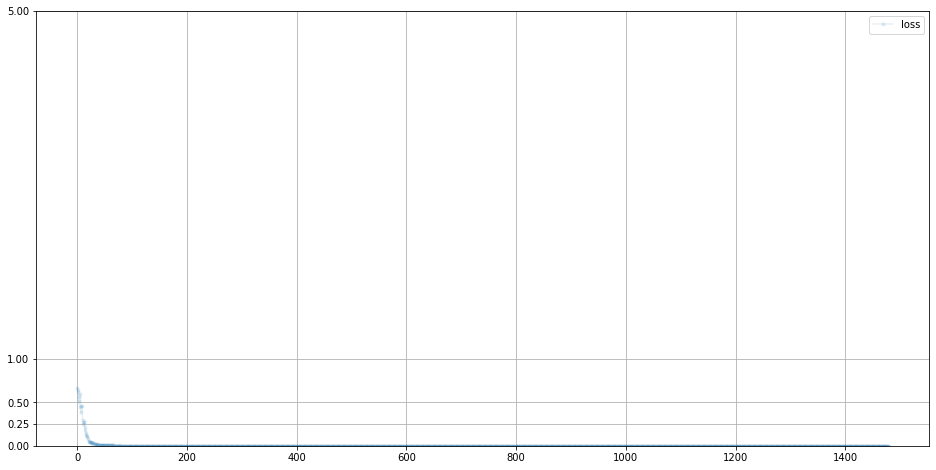

In [105]:
# plot discriminator loss

D.plot_progress()
     

In [108]:
# manually run discriminator to check it can tell real data from fake
import random
for i in range(4):
  image_data_tensor = gait90_dataset[random.randint(0,7400)]
  print( D.forward( image_data_tensor ).item() )
  pass

for i in range(4):
  print( D.forward( generate_random_image((1,1,64,64))).item() )
  pass

1.0
1.0
1.0
1.0
1.0817515203598305e-06
4.2642636799428146e-07
6.08042341809778e-07
2.6163010602431314e-07


In [109]:
# generator class

class Generator(nn.Module):
    
    def __init__(self):
        # initialise parent pytorch class
        super().__init__()
        
        # define neural network layers
        self.model = nn.Sequential(
            # input is a 1d array
            nn.Linear(50, 3*6*6),
            nn.LeakyReLU(0.2),
            
            # reshape to 4d
            View((1, 3, 6, 6)),
            
            nn.ConvTranspose2d(3, 128, kernel_size=6, stride=2),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),

            nn.ConvTranspose2d(128, 128, kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),

            nn.ConvTranspose2d(128, 1, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(1),
            
            # output should be (1,3,128,128)
            nn.Sigmoid()
        )
        
        # create optimiser, simple stochastic gradient descent
        self.optimiser = torch.optim.Adam(self.parameters(), lr=0.0001)

        # counter and accumulator for progress
        self.counter = 0;
        self.progress = []
        
        pass
    
    
    def forward(self, inputs):        
        # simply run model
        return self.model(inputs)
    
    
    def train(self, D, inputs, targets):
        # calculate the output of the network
        g_output = self.forward(inputs)
        
        # pass onto Discriminator
        d_output = D.forward(g_output)
        
        # calculate error
        loss = D.loss_function(d_output, targets)

        # increase counter and accumulate error every 10
        self.counter += 1;
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass

        # zero gradients, perform a backward pass, update weights
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

        pass
    
    
    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5, 1.0, 5.0))
        pass
    
    pass

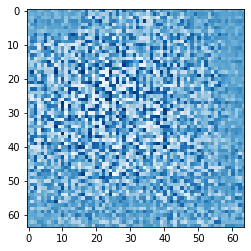

In [110]:
# check the generator output is of the right type and shape

G = Generator()
# move model to cuda device
G.to(device)

output = G.forward(generate_random_seed(50))

img = output.detach().permute(0,2,3,1).view(64,64,1).cpu().numpy()

plt.imshow(img, interpolation='none', cmap='Blues')

In [125]:
%%time 

# create Discriminator and Generator

D = Discriminator()
G = Generator()
D.to(device)
G.to(device)

epochs = 1

for epoch in range(epochs):
  print ("epoch = ", epoch + 1)

  # train Discriminator and Generator

  for image_data_tensor in gait90_dataset:
    # train discriminator on true
    D.train(image_data_tensor, torch.cuda.FloatTensor([1.0]))
    
    # train discriminator on false
    # use detach() so gradients in G are not calculated
    D.train(G.forward(generate_random_seed(50)).detach(), torch.cuda.FloatTensor([0.0]))
    
    # train generator
    G.train(D, generate_random_seed(50), torch.cuda.FloatTensor([1.0]))

    pass
    
  pass

epoch =  1
counter =  1000
counter =  2000
counter =  3000
counter =  4000
counter =  5000
counter =  6000
counter =  7000
counter =  8000
counter =  9000
counter =  10000
counter =  11000
counter =  12000
counter =  13000
counter =  14000
CPU times: user 1min 46s, sys: 1.28 s, total: 1min 47s
Wall time: 1min 48s


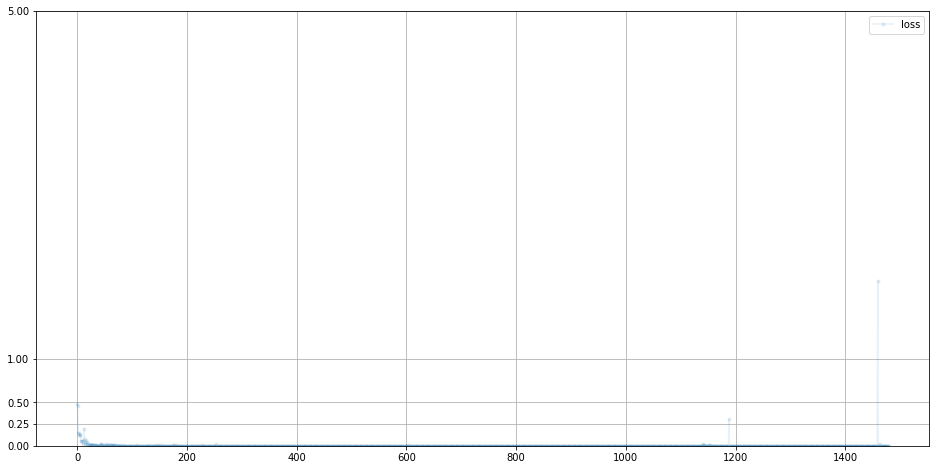

In [126]:
D.plot_progress()

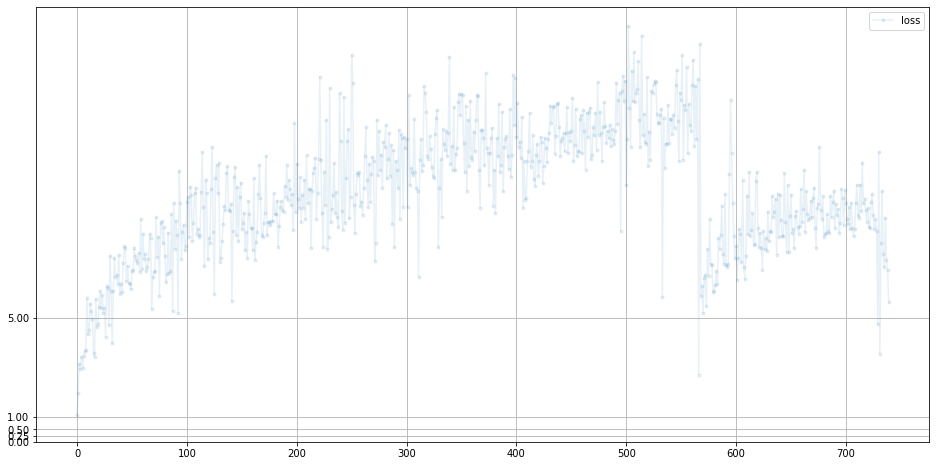

In [127]:
G.plot_progress()

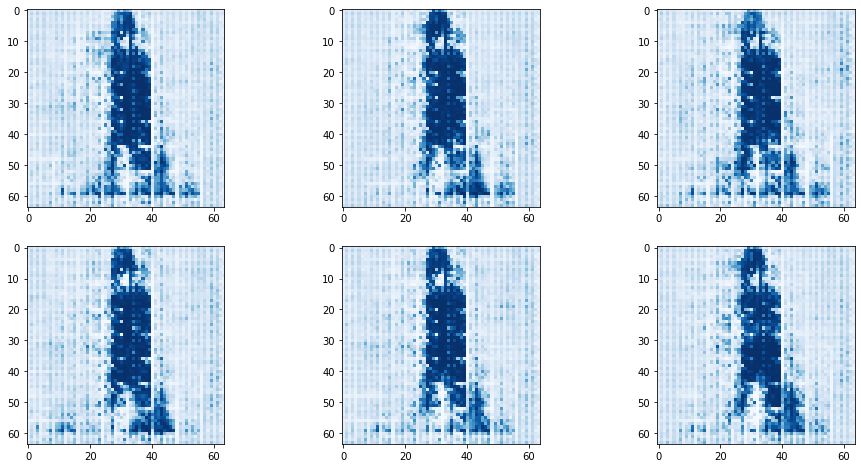

In [129]:
f, axarr = plt.subplots(2,3, figsize=(16,8))
for i in range(2):
    for j in range(3):
        output = G.forward(generate_random_seed(50))
        img = output.detach().permute(0,2,3,1).view(64,64,1).cpu().numpy()
        axarr[i,j].imshow(img, interpolation='none', cmap='Blues')
        pass
    pass